In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from xml.dom import minidom
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data_directory = "./data/pan21-author-profiling-training-2021-03-14/en" 

text_list = []
label_list = []
with open(data_directory+"/truth.txt") as f:
    for l in f.readlines():
        l = l.rstrip().split(":::")
        user_id = l[0]
        label = int(l[1])
        xml_file = minidom.parse(data_directory+"/"+user_id+".xml")
        document_list = xml_file.getElementsByTagName('document')
        aux = []
        for i, doc in enumerate(document_list):
            aux.append(doc.firstChild.nodeValue)
        #aux = " ".join(aux)
        text_list.append(aux)
        label_list.append(label)
label_list = np.array(label_list)

print(len(text_list), "Total users")

200 Total users


In [80]:
vocab_size = 500
maxlen = 80
test_split = 0.1
val_split = 0.5

x_train_r, x_test_r, y_train, y_test = train_test_split(text_list, label_list, \
                                                        test_size=test_split, random_state=42)

tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(map(" ".join, x_train_r))

x_train = list(map(lambda x: tokenizer.texts_to_sequences(x), x_train_r))
x_test = list(map(lambda x: tokenizer.texts_to_sequences(x), x_test_r))

x_train = np.array(list(map(lambda x: keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen), x_train)))
x_test = np.array(list(map(lambda x: keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen), x_test)))

x_train.shape

(180, 200, 80)

In [81]:
emb_dim = 1

inputs = layers.Input(shape=x_train.shape[1:])
x = layers.Embedding(vocab_size, emb_dim, input_length=maxlen)(inputs)
x = layers.Conv1D(8, kernel_size=7, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv1D(8, kernel_size=5, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv1D(8, kernel_size=3, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv1D(8, kernel_size=3, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.Lambda(lambda y: tf.math.reduce_mean(y, axis=2))(x)
#x = layers.Lambda(lambda y: tf.squeeze(y, 2))(x)
#x = layers.LSTM(16, dropout=0.5, return_sequences=True)(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Conv1D(16, kernel_size=3, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Lambda(lambda y: tf.squeeze(y, 2))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)
outputs = layers.Activation("sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 200, 80)]         0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 200, 80, 1)        500       
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 200, 37, 8)        64        
_________________________________________________________________
batch_normalization_155 (Bat (None, 200, 37, 8)        32        
_________________________________________________________________
activation_188 (Activation)  (None, 200, 37, 8)        0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 200, 17, 8)        328       
_________________________________________________________________
batch_normalization_156 (Bat (None, 200, 17, 8)        32 

In [82]:
history = model.fit(
    x_train, y_train, batch_size=16, epochs=200, validation_split=val_split
)

Epoch 1/200
6/6 [==============================] - 2s 112ms/step - loss: 0.7235 - accuracy: 0.5083 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/200
6/6 [==============================] - 0s 38ms/step - loss: 0.7178 - accuracy: 0.4743 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/200
6/6 [==============================] - 0s 34ms/step - loss: 0.6885 - accuracy: 0.5487 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/200
6/6 [==============================] - 0s 32ms/step - loss: 0.7053 - accuracy: 0.4553 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 0s 36ms/step - loss: 0.6955 - accuracy: 0.4789 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/200
6/6 [==============================] - 0s 35ms/step - loss: 0.6895 - accuracy: 0.5177 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 7/200
6/6 [==============================] - 0s 37ms/step - loss: 0.6789 - accuracy: 0.5433 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 8/200
6/6 [==

6/6 [==============================] - 0s 36ms/step - loss: 0.3223 - accuracy: 1.0000 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 60/200
6/6 [==============================] - 0s 33ms/step - loss: 0.3089 - accuracy: 1.0000 - val_loss: 0.7178 - val_accuracy: 0.5000
Epoch 61/200
6/6 [==============================] - 0s 35ms/step - loss: 0.3059 - accuracy: 1.0000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 62/200
6/6 [==============================] - 0s 34ms/step - loss: 0.2793 - accuracy: 1.0000 - val_loss: 0.7366 - val_accuracy: 0.5000
Epoch 63/200
6/6 [==============================] - 0s 34ms/step - loss: 0.2762 - accuracy: 1.0000 - val_loss: 0.6710 - val_accuracy: 0.5778
Epoch 64/200
6/6 [==============================] - 0s 37ms/step - loss: 0.2635 - accuracy: 1.0000 - val_loss: 0.8220 - val_accuracy: 0.5222
Epoch 65/200
6/6 [==============================] - 0s 31ms/step - loss: 0.2929 - accuracy: 0.9928 - val_loss: 1.3221 - val_accuracy: 0.5000
Epoch 66/200
6/6 [========

Epoch 117/200
6/6 [==============================] - 0s 35ms/step - loss: 0.1118 - accuracy: 1.0000 - val_loss: 80.0541 - val_accuracy: 0.5000
Epoch 118/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0996 - accuracy: 1.0000 - val_loss: 94.8469 - val_accuracy: 0.5000
Epoch 119/200
6/6 [==============================] - 0s 34ms/step - loss: 0.1025 - accuracy: 1.0000 - val_loss: 118.0630 - val_accuracy: 0.5000
Epoch 120/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0923 - accuracy: 1.0000 - val_loss: 130.3512 - val_accuracy: 0.5000
Epoch 121/200
6/6 [==============================] - 0s 34ms/step - loss: 0.1002 - accuracy: 1.0000 - val_loss: 133.9629 - val_accuracy: 0.5000
Epoch 122/200
6/6 [==============================] - 0s 36ms/step - loss: 0.0913 - accuracy: 1.0000 - val_loss: 150.6836 - val_accuracy: 0.5000
Epoch 123/200
6/6 [==============================] - 0s 36ms/step - loss: 0.0843 - accuracy: 1.0000 - val_loss: 148.2766 - val_accuracy: 0

6/6 [==============================] - 0s 34ms/step - loss: 0.0472 - accuracy: 1.0000 - val_loss: 0.9683 - val_accuracy: 0.4222
Epoch 175/200
6/6 [==============================] - 0s 36ms/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 1.1248 - val_accuracy: 0.4222
Epoch 176/200
6/6 [==============================] - 0s 36ms/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 10.3212 - val_accuracy: 0.5000
Epoch 177/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0476 - accuracy: 1.0000 - val_loss: 28.6183 - val_accuracy: 0.5000
Epoch 178/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 19.7563 - val_accuracy: 0.5000
Epoch 179/200
6/6 [==============================] - 0s 39ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 16.5493 - val_accuracy: 0.5000
Epoch 180/200
6/6 [==============================] - 0s 37ms/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 15.1340 - val_accuracy: 0.5000
Epoch 181/200
6

In [83]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32)
print("%.3f" % test_acc, "Testing accuracy")

1/1 [==============================] - 0s 25ms/step - loss: 50.9787 - accuracy: 0.5000
0.500 Testing accuracy


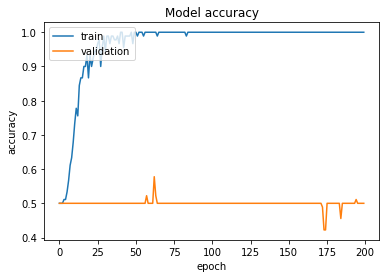

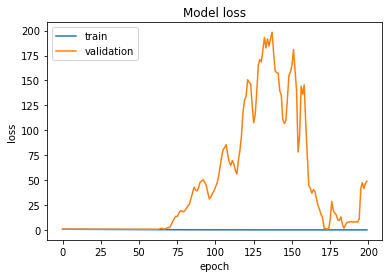

In [84]:
from matplotlib import pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()